# Fine Tune Extraction configuration

In [1]:
import os

import h5py
import matplotlib.pyplot as plt
import numpy as np

from scportrait.pipeline.extraction import HDF5CellExtraction
from scportrait.pipeline.project import Project
from scportrait.pipeline.segmentation.workflows import CytosolSegmentationCellpose

/Users/sophia/mambaforge/envs/scPortrait_dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
project_location = "project_extraction_config"

project = Project(
    os.path.abspath(project_location),
    config_path="config_example1.yml",
    overwrite=True,
    debug=False,
    segmentation_f=CytosolSegmentationCellpose,
    extraction_f=HDF5CellExtraction,
)

Updating project config file.


In [5]:
from scportrait.data._datasets import dataset_7

dataset_7_path = dataset_7()

images = [f"{dataset_7_path}/Ch1.tif", f"{dataset_7_path}/Ch2.tif", f"{dataset_7_path }/Ch3.tif", f"{dataset_7_path }/Ch4.tif"]

project.load_input_from_tif_files(images)

Downloading...: 100%|██████████| 6.48M/6.48M [00:02<00:00, 3.06MB/s]

INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/development/project_extraction_config/scportr
         ait.sdata                                                                                                 


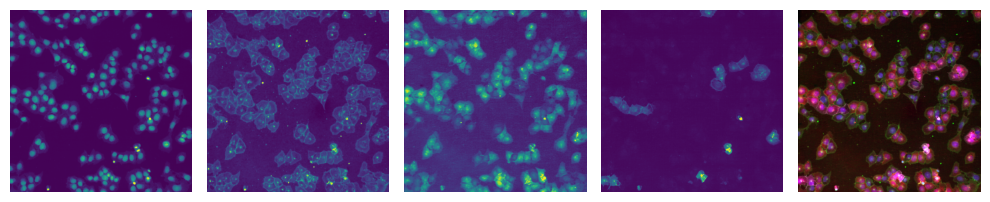

In [7]:
# visualize input images as example
# it is not recommended to execute this block with large input images as it will compute for some time

from scportrait.plotting.vis import generate_composite

fig, axs = plt.subplots(1, 5, figsize=(10, 4))
axs[0].imshow(project.input_image[0])
axs[0].axis("off")

axs[1].imshow(project.input_image[1])
axs[1].axis("off")

axs[2].imshow(project.input_image[2])
axs[2].axis("off")

axs[3].imshow(project.input_image[3])
axs[3].axis("off")

img = generate_composite(project.input_image)

axs[4].imshow(img)
axs[4].axis("off")

fig.tight_layout()

In [8]:
project.segment()

/Users/sophia/mambaforge/envs/scPortrait_dev/lib/python3.11/site-packages/cellpose/dynamics.py:189: RuntimeWarning: invalid value encountered in divide
  mu /= (1e-60 + (mu**2).sum(axis=0)**0.5)
/Users/sophia/mambaforge/envs/scPortrait_dev/lib/python3.11/site-packages/cellpose/dynamics.py:189: RuntimeWarning: invalid value encountered in divide
  mu /= (1e-60 + (mu**2).sum(axis=0)**0.5)


(-0.5, 1078.5, 1078.5, -0.5)

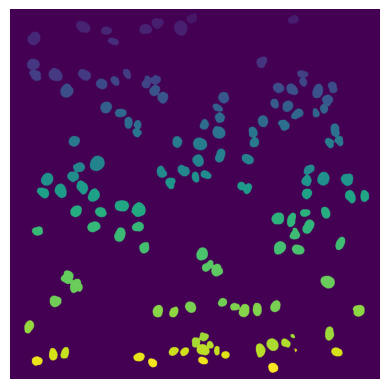

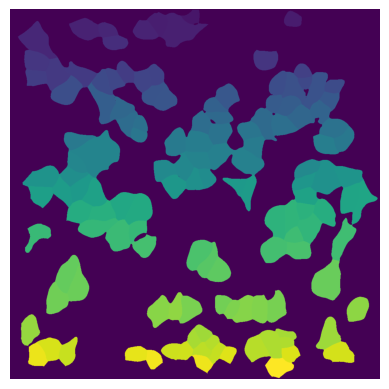

In [9]:
plt.figure()
plt.imshow(project.sdata["seg_all_nucleus"])
plt.axis("off")

plt.figure()
plt.imshow(project.sdata["seg_all_cytosol"])
plt.axis("off")

Extracting cell batches: 100%|██████████| 1/1 [00:00<00:00, 32.49it/s]


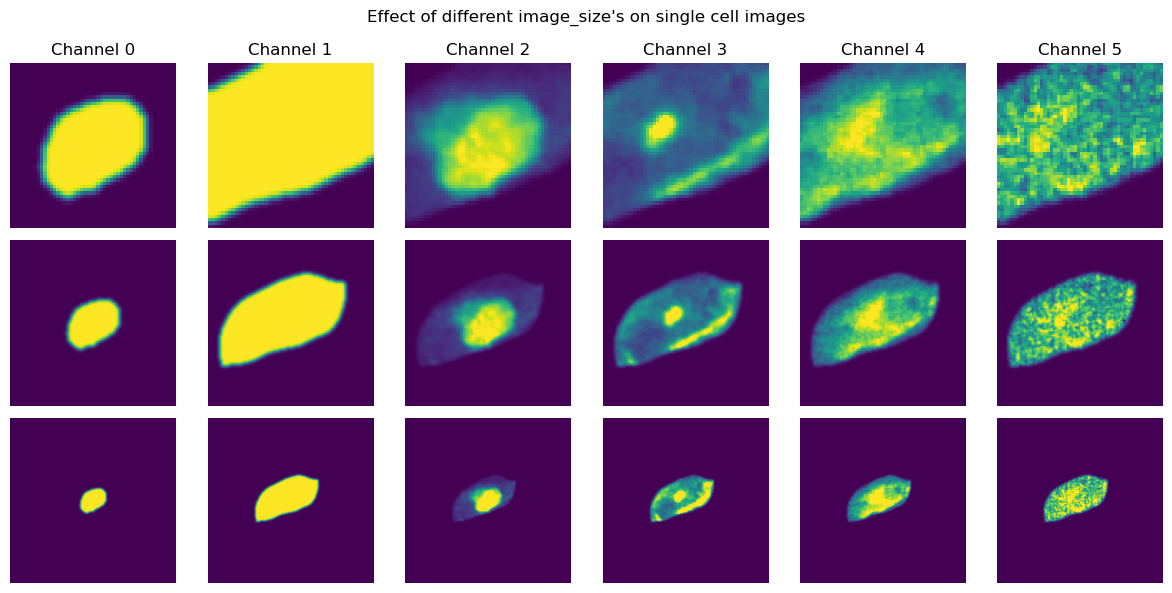

In [10]:
n_channels = 6
cell_id = None
conditions = [50, 100, 200]
fig, axs = plt.subplots(len(conditions), n_channels, figsize=(2 * n_channels, 2 * len(conditions)))

for i, image_size in enumerate(conditions):
    project.config["HDF5CellExtraction"]["image_size"] = image_size
    project._update_extraction_f(HDF5CellExtraction)
    project.extract(partial=True, n_cells=2, seed = 92)

    single_cell_data = project.extraction_f.output_path
    with h5py.File(single_cell_data, "r") as f:
        lookup = dict(zip(f["single_cell_index"][:, 1], f["single_cell_index"][:, 0], strict = True))
        if cell_id is None:
            cell_id = list(lookup.keys())[0]
        index = lookup[cell_id]
        images = f['single_cell_data'][index:index + 1]

    for j in range(n_channels):
        axs[i, j].imshow(images[0][j], vmin = 0, vmax = 1)
        axs[i, j].axis("off")

        if i == 0:
            axs[i, j].set_title(f"Channel {j}")
    axs[i, 0].set_ylabel(f"Image size {image_size}")
    axs[i, 0].yaxis.set_visible(True)  # Make sure the y-axis is visible
    axs[i, 0].yaxis.set_ticks([])

fig.suptitle("Effect of different image_size's on single cell images")
fig.tight_layout()


Extracting cell batches: 100%|██████████| 1/1 [00:00<00:00, 40.81it/s]


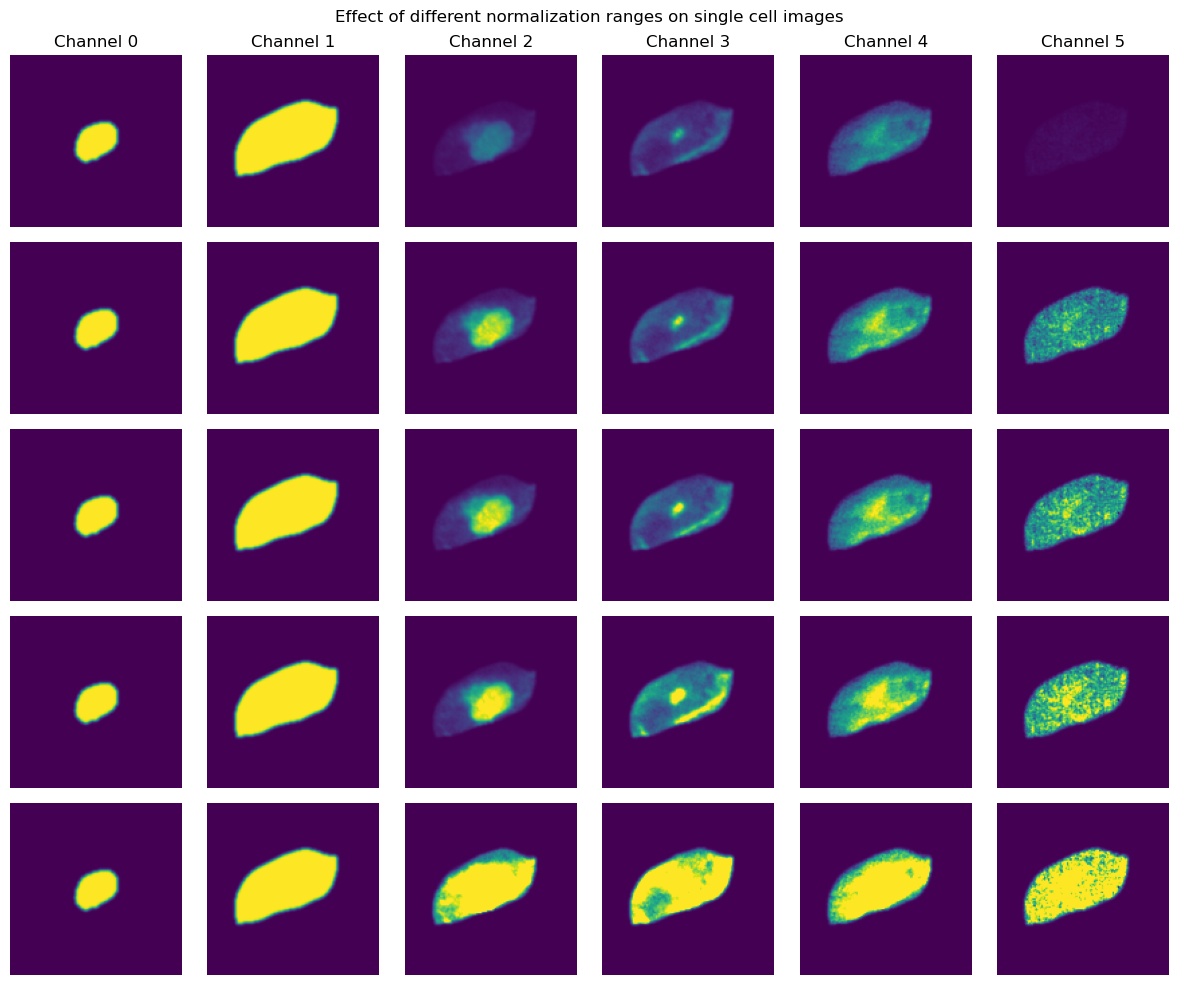

In [11]:
n_channels = 6
conditions = [(0, 1), (0.001, 0.999), (0.01, 0.99), (0.1, 0.9)]
fig, axs = plt.subplots(len(conditions) + 1, n_channels, figsize=(2 * n_channels, 2 * (len(conditions)+ 1)))

project.config["HDF5CellExtraction"]["image_size"] = 128
project.config["HDF5CellExtraction"]["normalize_output"] = False
project._update_extraction_f(HDF5CellExtraction)
project.extract(partial=True, n_cells=2, seed = 92)

single_cell_data = project.extraction_f.output_path
with h5py.File(single_cell_data, "r") as f:
    lookup = dict(zip(f["single_cell_index"][:, 1], f["single_cell_index"][:, 0], strict = True))
    index = lookup[cell_id]
    images = f['single_cell_data'][index:index + 1]

for j in range(n_channels):
    axs[0, j].imshow(images[0][j], vmin = 0, vmax = 1)
    axs[0, j].axis("off")
    axs[0, j].set_title(f"Channel {j}")


for i, normalization_range in enumerate(conditions):

    project.config["HDF5CellExtraction"]["normalize_output"] = True
    project.config["HDF5CellExtraction"]["normalization_range"] = normalization_range
    project._update_extraction_f(HDF5CellExtraction)
    project.extract(partial=True, n_cells=2, seed = 92)

    single_cell_data = project.extraction_f.output_path
    with h5py.File(single_cell_data, "r") as f:
        lookup = dict(zip(f["single_cell_index"][:, 1], f["single_cell_index"][:, 0], strict = True))
        index = lookup[cell_id]
        images = f['single_cell_data'][index:index + 1]

    for j in range(n_channels):
        axs[i + 1, j].imshow(images[0][j], vmin = 0, vmax = 1)
        axs[i + 1, j].axis("off")

fig.suptitle("Effect of different normalization ranges on single cell images")
fig.tight_layout()
